In [1]:
#Objectives: 
#Nous allons parcourir la base de données de Mercedes Benz 
#Cette base de données contient les différentes options des voitures constuites,
#C'est variables sont d'écrites sous forme de variables anonymes
#La variable Y représente le temps qu'une voiture passe dans la borne de test 


In [2]:
# importer ici les librairies dont vous aurez besoin

# pandas
import pandas as pd
from pandas import Series,DataFrame

# numpy, matplotlib, seaborn
import numpy as np
import matplotlib.pyplot as plt
import pylab as P
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

# machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from xgboost import XGBRegressor

from sklearn.pipeline import make_pipeline, make_union
from sklearn.base import BaseEstimator,TransformerMixin, ClassifierMixin
from sklearn.linear_model import ElasticNetCV, LassoLarsCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.utils import check_array

from sklearn.metrics import r2_score

C:\anacanda\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
class StackingEstimator(BaseEstimator, TransformerMixin):
    
    def __init__(self, estimator):
        self.estimator = estimator

    def fit(self, X, y=None, **fit_params):
        self.estimator.fit(X, y, **fit_params)
        return self
    def transform(self, X):
        X = check_array(X)
        X_transformed = np.copy(X)
        # add class probabilities as a synthetic feature
        if issubclass(self.estimator.__class__, ClassifierMixin) and hasattr(self.estimator, 'predict_proba'):
            X_transformed = np.hstack((self.estimator.predict_proba(X), X))

        # add class prodiction as a synthetic feature
        X_transformed = np.hstack((np.reshape(self.estimator.predict(X), (-1, 1)), X_transformed))

        return X_transformed

In [4]:
import itertools


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Importation des données:

In [5]:
#récuperation des données 
#données pour le train
data_train = pd.read_csv("data/train.csv")
#données pour le test 
data_test = pd.read_csv("data/test.csv")


# Exploration des données:

In [6]:
#dimension du train et test: 
data_train.shape
print("Notre jeu de donnée train est de dimension:",data_train.shape)
print("Notre jeu de donnée test est de dimension:",data_test.shape)


Notre jeu de donnée train est de dimension: (4209, 378)
Notre jeu de donnée test est de dimension: (4209, 377)


In [7]:
#une aperçu sur le train 
data_train.head()

,ID,y,X0,X1,X2,X3,X4,X5,X6,X8,...,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385
0,0,130.81,k,v,at,a,d,u,j,o,...,0,0,1,0,0,0,0,0,0,0
1,6,88.53,k,t,av,e,d,y,l,o,...,1,0,0,0,0,0,0,0,0,0
2,7,76.26,az,w,n,c,d,x,j,x,...,0,0,0,0,0,0,1,0,0,0
3,9,80.62,az,t,n,f,d,x,l,e,...,0,0,0,0,0,0,0,0,0,0
4,13,78.02,az,v,n,f,d,h,d,n,...,0,0,0,0,0,0,0,0,0,0


In [8]:
#Recherche de valeurs manquantes 
print(data_train.isnull().sum().sum())

0


On peut voir qu'il y a pas des valeurs manquantes


In [9]:
data_train.isnull().values.any()

False

In [10]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4209 entries, 0 to 4208
Columns: 378 entries, ID to X385
dtypes: float64(1), int64(369), object(8)
memory usage: 12.1+ MB


On a 8 variables qualitatives et 369 variables boolein 

La variable Y est la variable temps passée par une voiture dans le branche de test pour chaque variable.
c'est la variable qu'on va prédir après 
   

In [11]:
#description de la variable réponse:
print(data_train["y"].describe(include='all'))

count    4209.000000
mean      100.669318
std        12.679381
min        72.110000
25%        90.820000
50%        99.150000
75%       109.010000
max       265.320000
Name: y, dtype: float64


In [12]:
dtype_data = data_train.dtypes.reset_index()
dtype_data.loc[:10,:]

,index,0
0,ID,int64
1,y,float64
2,X0,object
3,X1,object
4,X2,object
5,X3,object
6,X4,object
7,X5,object
8,X6,object
9,X8,object


On remarque que les variables "X0","X1","X2","X3","X4","X5","X6","X8" sont les variables qualitatives 
tandis que notre variables réponse "y" est un réel

In [13]:
#datacor=data_train.iloc[0:,10:]

In [14]:
#corr = datacor.corr() # matrix de correlation
#f, ax = plt.subplots(figsize=(11, 9))
#sns.heatmap(corr,annot=True, vmax=.3)
#plt.show()


In [15]:
#import seaborn as sns
#corr = data_uant.corr()
#sns.heatmap(corr, 
           # xticklabels=corr.columns.values,
           # yticklabels=corr.columns.values)

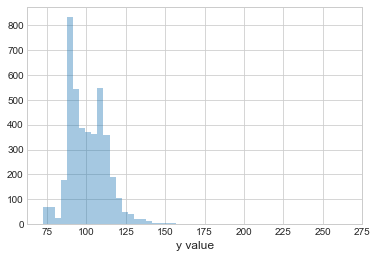

In [16]:
sns.distplot(data_train.y.values, bins=50, kde=False)
plt.xlabel('y value', fontsize=12)
plt.show()

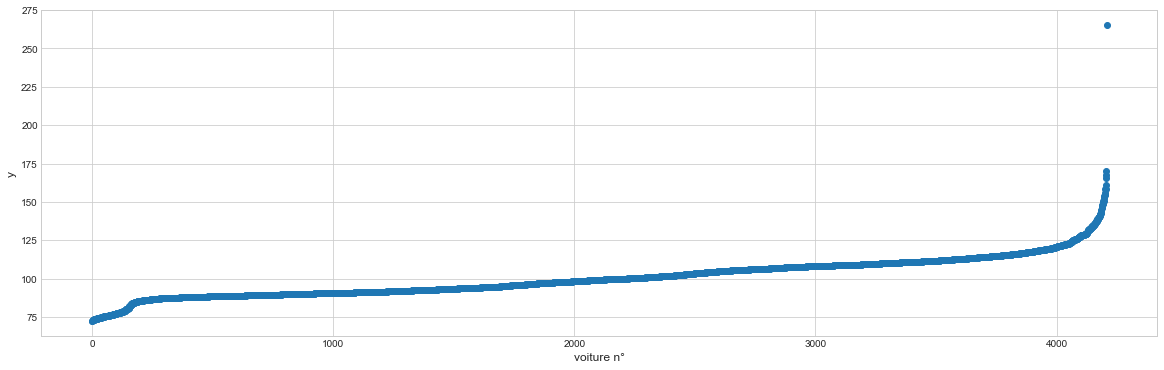

In [32]:
#on va voir la réaction de la variable Y
plt.figure(figsize=(20,6))
plt.scatter(range(data_train.shape[0]), np.sort(data_train.y.values))
plt.xlabel('voiture n°', fontsize=12)
plt.ylabel('y', fontsize=12)
plt.show()

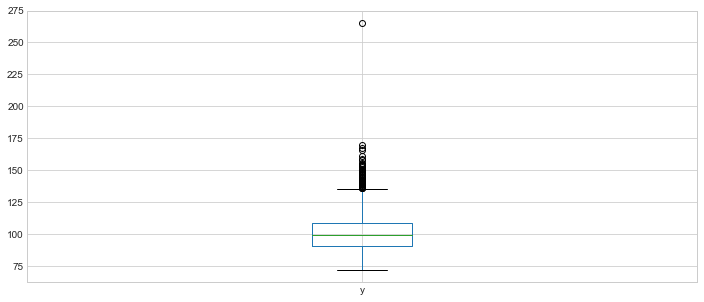

In [42]:
data_train["y"].plot(kind="box",figsize=(12,5))


# Exploration de la variable X0

C:\anacanda\lib\site-packages\numpy\core\fromnumeric.py:57: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


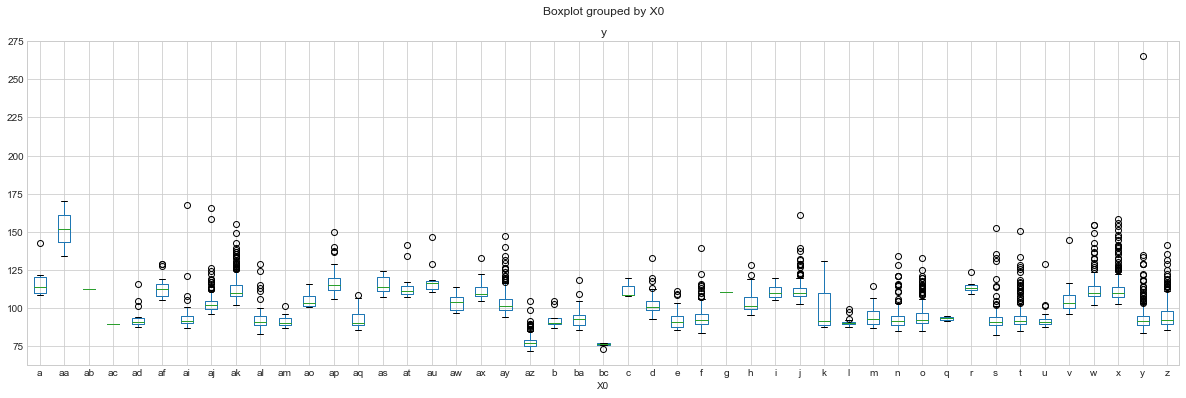

In [72]:

data_train.boxplot(column="y",by="X0",figsize=(20,6)) 


In [49]:
# table de contingence
#Un tableau de contingence est une manière efficace de résumer la relation entre deux variables qualitatives
table=pd.crosstab(data_train["X1"],data_train["X0"])
print(table)

X0   a  aa  ab  ac  ad  af  ai  aj   ak  al ...   q  r   s    t  u   v    w  \
X1                                          ...                               
a    0   0   0   0   4   0   0   4    2   3 ...   0  0   0    0  1   0    0   
aa   0   0   0   0   0   0   4   0    0   3 ...   0  0  54  111  0   0    0   
ab   0   0   0   0   0   0   0   0    0   0 ...   0  0   0    0  0   0    0   
b    0   0   0   0   0   0  22   0    0   4 ...   0  0  30  151  0   0    0   
c    0   0   0   0   0   2   0   6   12   0 ...   0  2   0    0  2   3    8   
d    0   0   0   0   0   0   0   0    0   0 ...   0  0   0    0  0   0    0   
e    0   0   0   0   0   4   0   4    7   0 ...   0  1   0    0  0   2    8   
f    0   0   0   0   0   0   3   0    0   0 ...   0  0   1    3  0   0    0   
g    0   0   0   0   0   0   0   0    0   0 ...   0  0   2    0  0   0    0   
h    0   0   0   0   2   0   0   2   10   0 ...   0  0   0    0  0   0    1   
i    0   0   0   0   0   0   1   0    0   0 ...   0 

# Exploration de la variable X1

C:\anacanda\lib\site-packages\numpy\core\fromnumeric.py:57: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


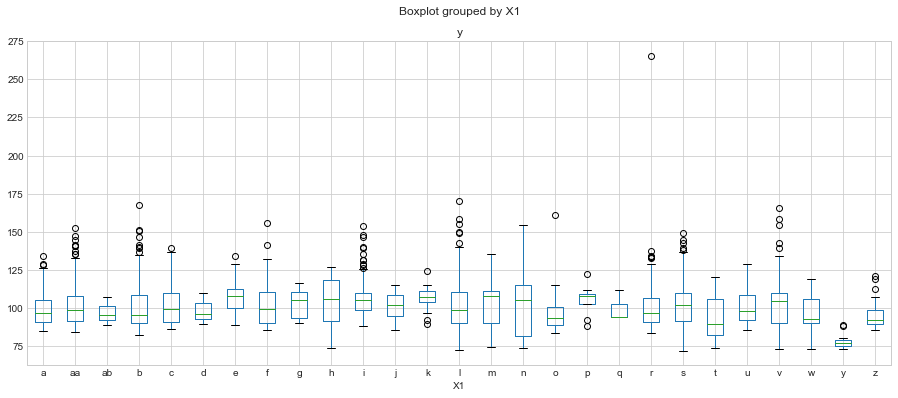

In [67]:
data_train.boxplot(column="y",by="X1",figsize=(15,6)) 


In [51]:
table=pd.crosstab(data_train["X1"],data_train["X2"])
print(table)

X2   a  aa  ac   ae  af  ag  ah   ai  ak  al ...   n  o  p  q   r   s   t  x  \
X1                                           ...                               
a    0   0   0   16   0   1   0    2  83   0 ...   0  0  3  0   4   0   0  2   
aa   0   0   0   29   0   1   4  195   8   0 ...   5  0  0  1   2   0   0  1   
ab   0   0   0    1   0   0   0    2   0   0 ...   0  0  0  0   0   0   0  0   
b   27   1   0   69   0   0   0  126  21   0 ...   7  0  0  0  10   0   0  0   
c    0   0   5   32   0   0   0    0   6   0 ...   2  0  0  0   6  10   0  0   
d    0   0   0    0   0   0   0    0   2   0 ...   0  0  0  0   0   0   0  0   
e    0   0   0    0   0   0   0    0   0   0 ...   0  0  0  0   0   0   0  0   
f    0   0   0    5   0   1   0    1   2   0 ...   0  0  0  0   0   0   0  0   
g    1   0   0    1   0   0   0    0   1   0 ...   0  0  0  0   0   0   0  0   
h    0   0   0    5   0   0   0    0   3   0 ...   2  0  0  0   0   1   0  0   
i    0   0   0   19   0   0   0    2   0

# Exploration de la variable X2

C:\anacanda\lib\site-packages\numpy\core\fromnumeric.py:57: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


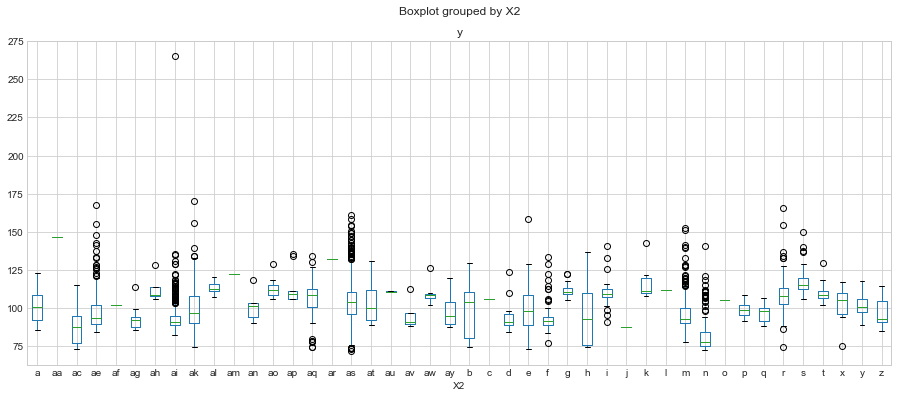

In [68]:
data_train.boxplot(column="y",by="X2",figsize=(15,6)) 


# Exploration de la variable X3

C:\anacanda\lib\site-packages\numpy\core\fromnumeric.py:57: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


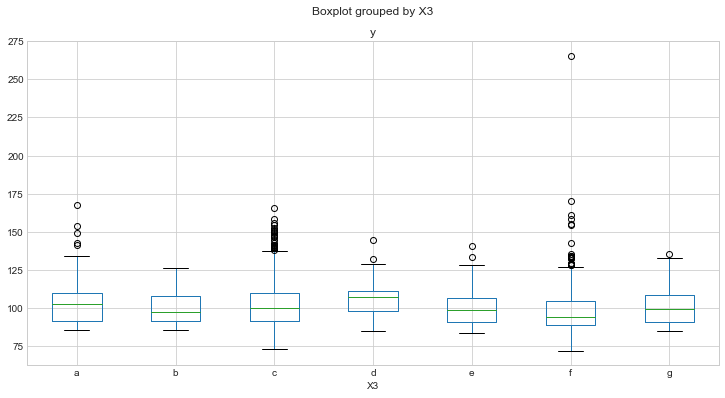

In [70]:
data_train.boxplot(column="y",by="X3",figsize=(12,6)) 


# Exploration de la variable X4

C:\anacanda\lib\site-packages\numpy\core\fromnumeric.py:57: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


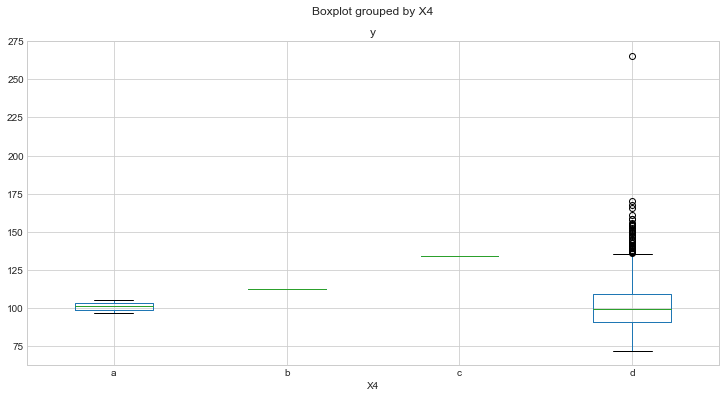

In [69]:
data_train.boxplot(column="y",by="X4",figsize=(12,6)) 


# Exploration de la variable X5

C:\anacanda\lib\site-packages\numpy\core\fromnumeric.py:57: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


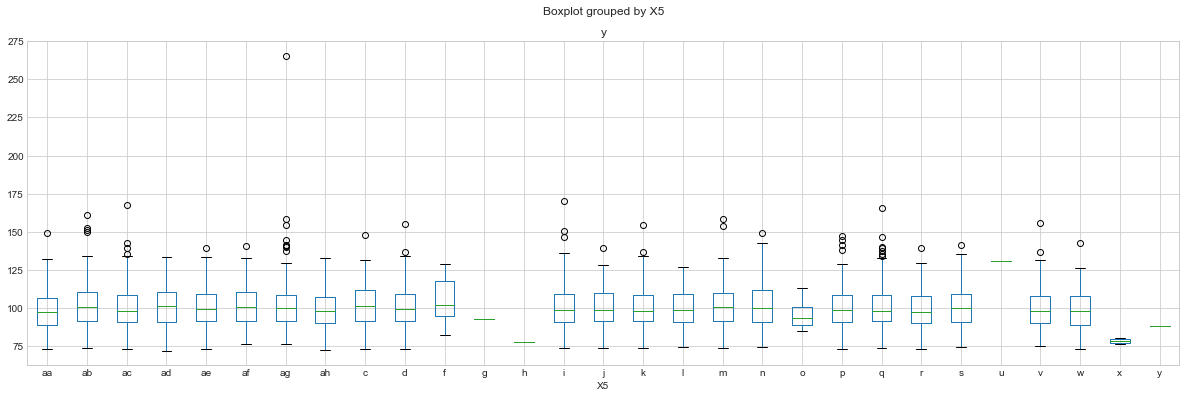

In [62]:
data_train.boxplot(column="y",by="X5",figsize=(20,6)) 


# Exploration de la variable X6

C:\anacanda\lib\site-packages\numpy\core\fromnumeric.py:57: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


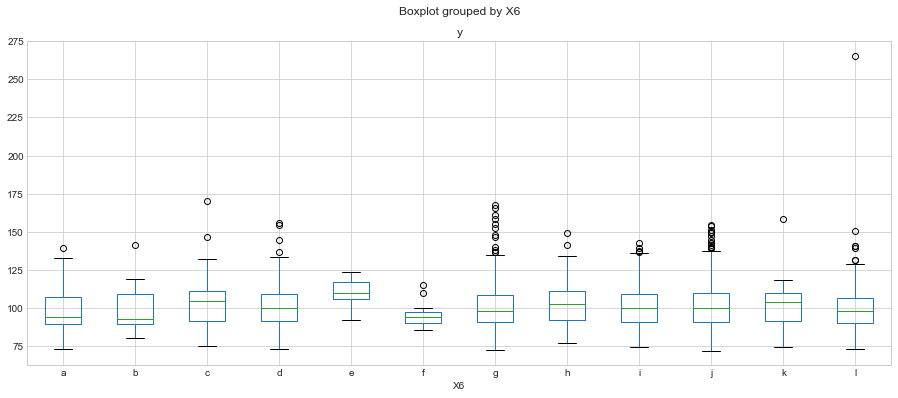

In [73]:
data_train.boxplot(column="y",by="X6",figsize=(15,6)) 


# Exploration de la variable X8

C:\anacanda\lib\site-packages\numpy\core\fromnumeric.py:57: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


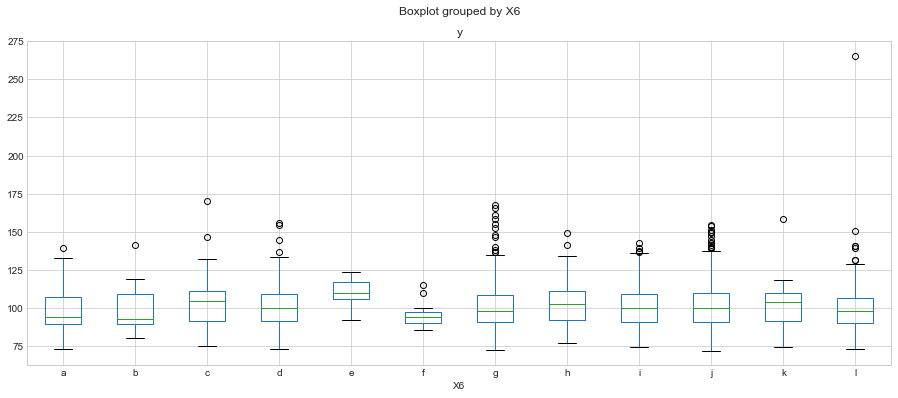

In [74]:
data_train.boxplot(column="y",by="X6",figsize=(15,6)) 


In [ ]:
data_train['X300'].value_counts()


In [53]:
data_train["y"].mean()

100.66931812782121

In [ ]:
#Données pour le test 
data_test = pd.read_csv("data/test.csv")

In [ ]:
#dimension du frame 
data_test.shape

In [ ]:
#data_test.head()

In [ ]:
#exploration de la variable X0
data_train['X0'].value_counts()


In [54]:
data_train[data_train["y"]>data_train["y"].mean()][["X0","X1","X2","X3"]]

,X0,X1,X2,X3
0,k,v,at,a
6,al,r,e,f
8,w,s,as,e
9,j,b,aq,c
10,h,r,r,f
16,al,r,e,f
17,ay,aa,as,c
22,x,r,a,b
23,x,b,m,c
26,aj,l,as,f


In [ ]:
#Extrere les colonnes des deux variables X10, X380
#data_train.ix[:,["X10","X380"]]

In [ ]:
test=data_train.as_matrix()
#print(test[:,10:385])

In [ ]:
#transfomer les objets en code numérique 

for c in data_train:
    if data_train[c].dtype == 'object':
        lbl = LabelEncoder()
        lbl.fit(list(data_train[c].values)+list(data_test[c].values))
        data_train[c] = lbl.transform(list(data_train[c].values))
        data_test[c]= lbl.transform(list(data_test[c].values))
     


In [ ]:
data_train.info()

In [ ]:
data_test.info()

In [ ]:
from sklearn.cross_validation import train_test_split

Y_train= data_train["y"].values
X_train= data_train.drop(["y","ID"], axis=1)
X_test = data_test.drop(["ID"], axis=1)



In [ ]:
data_test.info()

In [ ]:
X_train.info()

data_train["eval_set"]

In [ ]:
#Train the xgb model then predict the test data

model_1 = XGBRegressor(learning_rate=0.01, n_estimators=400, subsample=0.8, 
                      colsample_bytree=0.8, max_depth =10)
model_1.fit(X_train, Y_train)

Y_predict = model_1.predict(X_test)

In [ ]:
#utilisation du GradientBoostingRegressor
stacked_pipeline = make_pipeline(
    StackingEstimator(estimator=LassoLarsCV(normalize=True)),
    StackingEstimator(estimator=GradientBoostingRegressor(learning_rate=0.001, loss="huber", max_depth=3, max_features=0.55, min_samples_leaf=18, min_samples_split=14, subsample=0.7)),
    LassoLarsCV()
)
stacked_pipeline.fit(X_train, Y_train)
results = stacked_pipeline.predict(X_test)

In [ ]:
from sklearn import *

In [ ]:
Y_predict

In [ ]:
Y_predict.mean()

In [ ]:
#prediction du temps de test pour chaque ID 
id_test = data_test['ID'].values
sub = pd.DataFrame()
sub['ID'] = id_test
sub['y'] = Y_predict
sub.to_csv('xgbpred_model.csv', index=False)

In [ ]:
id_test = data_test['ID'].values
sub = pd.DataFrame()
sub['ID'] = id_test
sub['y'] = Y_predict*0.6 + results*0.4
sub.to_csv('xgbpred&stacked_pipeline.csv', index=False)


In [ ]:
#GradientBoostingRegressor
id_test = data_test['ID'].values
sub = pd.DataFrame()
sub['ID'] = id_test
sub['y'] = results
sub.to_csv('GradientBoostingRegressor.csv', index=False)


In [ ]:

#R2 Score on the entire Train data when averaging'''

print('score R2 pour le model 3')
print(r2_score(Y_train,stacked_pipeline.predict(X_train)))

In [ ]:
#R2 Score on the entire Train data when averaging'''

print('score R2 pour le model 1')
print(r2_score(Y_train,model.predict(X_train)))